## Estimation on 10x data using loom and pagoda2

元URL: http://pklab.med.harvard.edu/velocyto/notebooks/R/DG1.nb.html

最終更新日：2021/5/2

ここでは`velocyto.R` と `Pagoda2`を用いてRNA速度解析を行うチュートリアルを紹介します。

In [2]:
library(velocyto.R)
library(pagoda2)

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘pagoda2’


The following object is masked from ‘package:velocyto.R’:

    armaCor




In [4]:
# データのダウンロード（１回でよい）
options(timeout=6000)
download.file("http://pklab.med.harvard.edu/velocyto/DG1/10X43_1.loom", "10X43_1.loom")

In [5]:
ldat <- read.loom.matrices("10X43_1.loom")

reading loom file via hdf5r...


### Pagoda2を用いた正規化とクラスタリング

データの正規化、次元削減、クラスタリングのためにPagoda2を使いますが、Seuratなど他のツールを用いることも可能です。

Pagoda2の入力にはspliced expression matrixを使います。
今回使うデータセットは既にフィルタリングされていますが、更なるフィルタリングをすることも可能です。

In [6]:
emat <- ldat$spliced
emat <- emat[,colSums(emat)>=1e3]

3396 cells, 25919 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

368 overdispersed genes ... 368

persisting ... 

 using gam 

done.



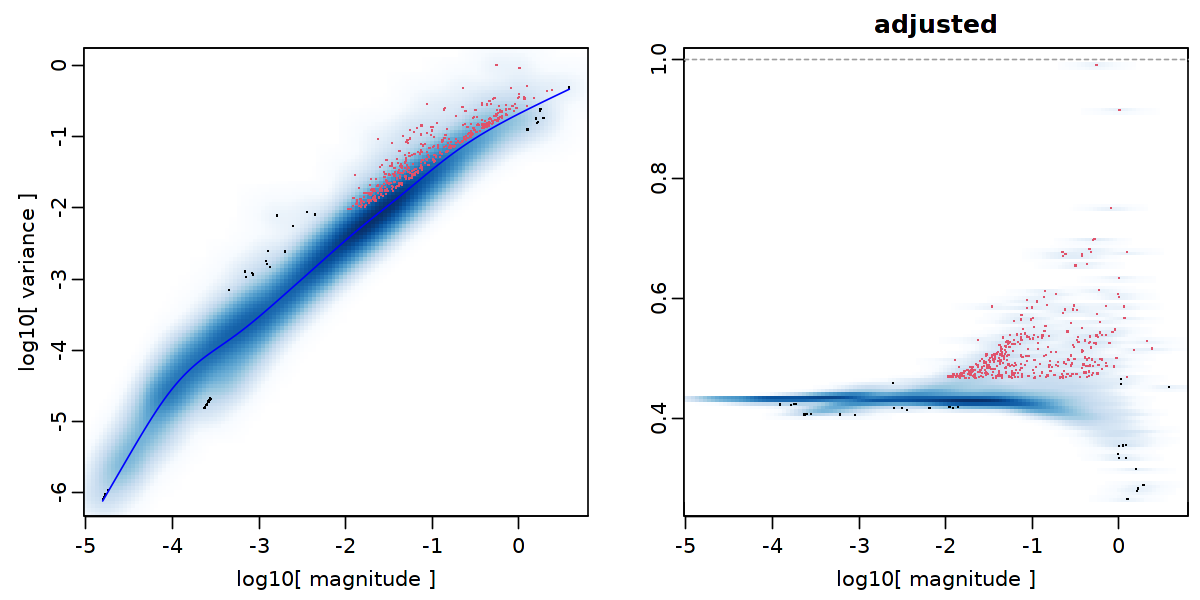

In [8]:
r <- Pagoda2$new(emat, modelType='plain', trim=10, log.scale=T)

options(repr.plot.width=10, repr.plot.height=5)
r$adjustVariance(plot=T, do.par=T, gam.k=10)

In [10]:
# PCA
r$calculatePcaReduction(nPcs=100, n.odgenes=3e3, maxit=300)

# K近傍グラフ
r$makeKnnGraph(k=30, type='PCA', center=T, distance='cosine');

# クラスタリング
r$getKnnClusters(method=multilevel.community,type='PCA',name='multilevel')

# tSNE
r$getEmbedding(type='PCA', embeddingType='tSNE', perplexity=50, verbose=T)

running PCA using 3000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


calculating distance ... 

pearson ...

running tSNE using 32 cores:




tSNE空間上でプロットします。

Warning message:
“Ignoring unknown parameters: mark.clusters, min.group.size, mark.cluster.cex, main”


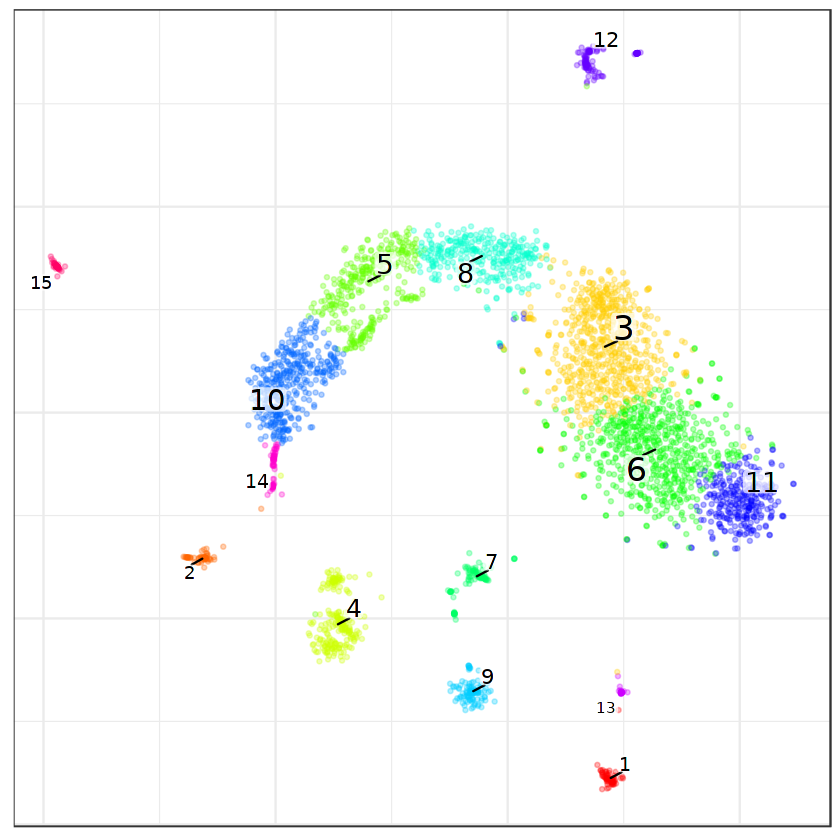

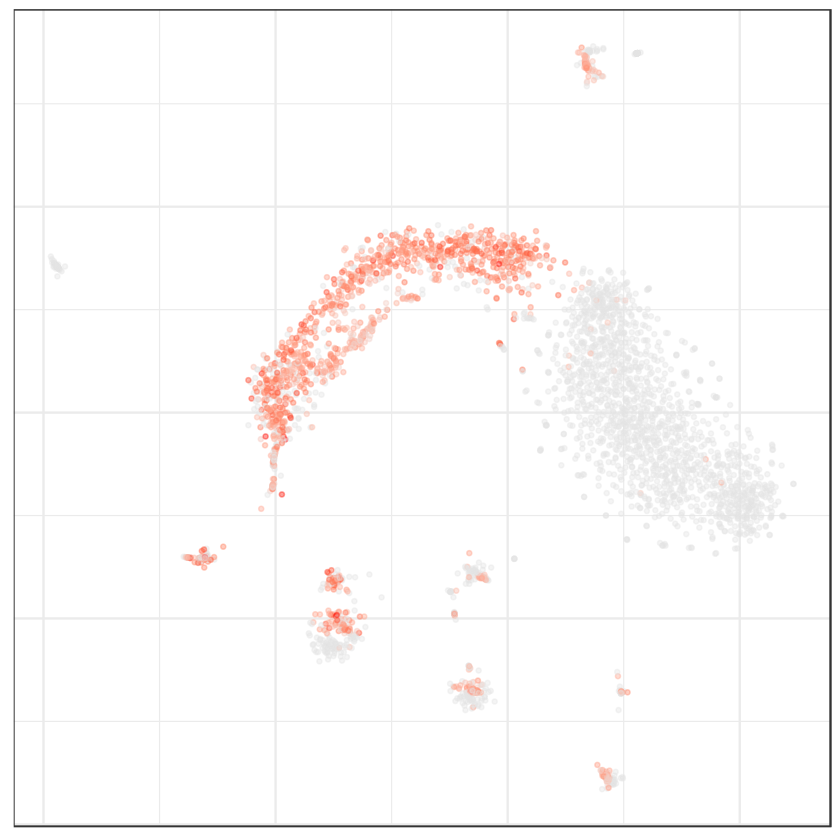

In [12]:
options(repr.plot.width=7, repr.plot.height=7)

par(mfrow=c(1,2))
r$plotEmbedding(type='PCA',
                embeddingType='tSNE',
                show.legend=F, 
                mark.clusters=T,
                min.group.size=10,
                shuffle.colors=F,
                mark.cluster.cex=1,
                alpha=0.3,
                main='cell clusters')
r$plotEmbedding(type='PCA',
                embeddingType='tSNE',
                colors=r$counts[,"Xist"],
                main='Xist')  

### RNA速度推定

In [13]:
emat <- ldat$spliced
nmat <- ldat$unspliced

# p2フィルタをパスした細胞のみにフィルタリング
emat <- emat[,rownames(r$counts)]
nmat <- nmat[,rownames(r$counts)]

# take cluster labels
cluster.label <- r$clusters$PCA[[1]]
cell.colors <- sccore::fac2col(cluster.label)

# take embedding
emb <- r$embeddings$PCA$tSNE

クラスタリングとt-SNEに加えて、p2の処理からcell-cell distanceを取得します。
これは、`velocyto.R` が通常使用するデフォルトの全トランスクリプトーム相関距離よりも優れています。

In [14]:
cell.dist <- as.dist(1 - armaCor(t(r$reductions$PCA)))

平均発現量の最小値に基づいて遺伝子をフィルタリングします。

In [15]:
emat <- filter.genes.by.cluster.expression(emat, cluster.label, min.max.cluster.average = 0.5)
nmat <- filter.genes.by.cluster.expression(nmat, cluster.label, min.max.cluster.average = 0.05)

# フィルタ後の遺伝子数を出力
length(intersect(rownames(emat), rownames(emat)))

[1] 3774

RNA速度の推定（gene-relative model, k=20のk最近傍法、ガンマフィットには上位/下位2%分位点を使用）。

In [17]:
fit.quantile <- 0.02
rvel.cd <- gene.relative.velocity.estimates(emat,
                                            nmat,
                                            deltaT = 1,
                                            kCells = 20,
                                            cell.dist = cell.dist,
                                            fit.quantile = fit.quantile)

calculating cell knn ... done
calculating convolved matrices ... done
fitting gamma coefficients ... done. succesfful fit for 1258 genes
filtered out 177 out of 1258 genes due to low nmat-emat correlation
filtered out 138 out of 1081 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


t-SNE上でRNA速度ベクトルフィールド可視化します。

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done
grid estimates ... grid.sd= 1.28619  min.arrow.size= 0.02572381  max.grid.arrow.length= 0.04539128  done


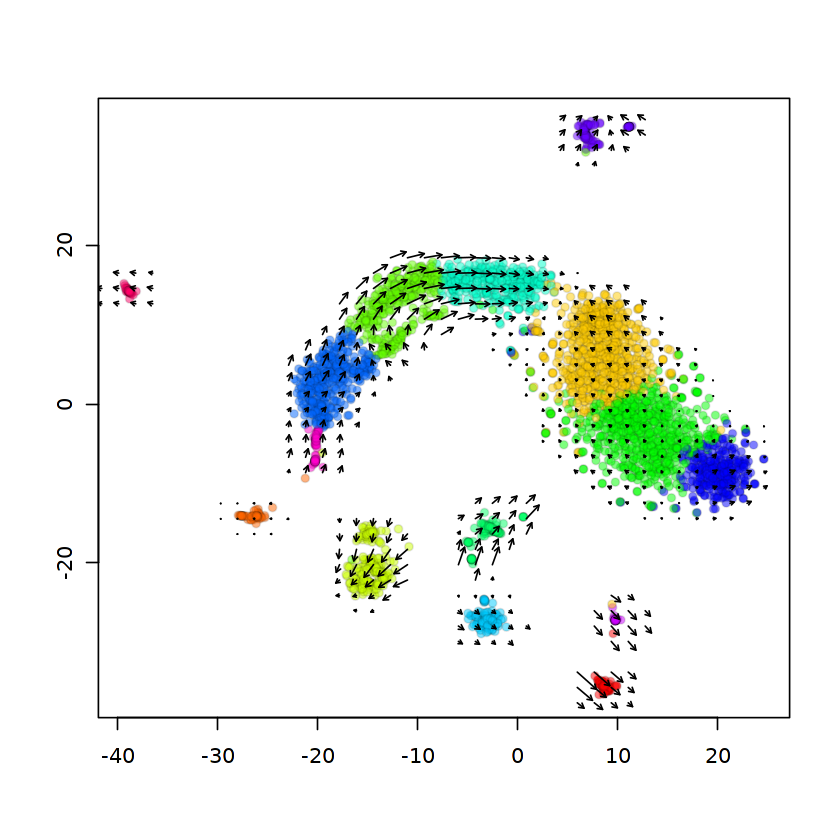

In [19]:
show.velocity.on.embedding.cor(emb,rvel.cd,n=300,
                               scale='sqrt',
                               cell.colors=ac(cell.colors,alpha=0.5),
                               cex=0.8,
                               arrow.scale=5,
                               show.grid.flow=TRUE,
                               min.grid.cell.mass=0.5,
                               grid.n=40,
                               arrow.lwd=1,
                               do.par=F,cell.border.alpha = 0.1)

特定の遺伝子に対するフィットを視覚化します（ここでは計算を省くために `rvel.cd` を再利用しています）。



calculating convolved matrices ... done


[1] 1

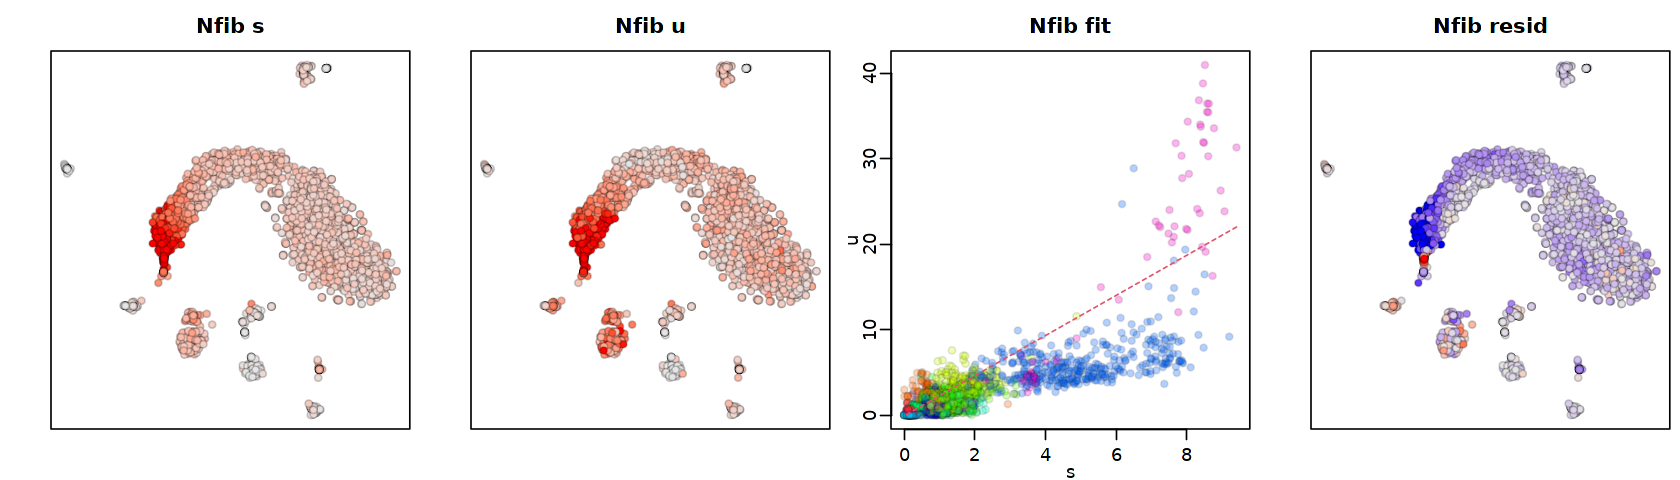

In [21]:
options(repr.plot.width=14, repr.plot.height=4)

gene <- "Nfib"
gene.relative.velocity.estimates(emat,nmat,
                                 deltaT=1,
                                 kCells = 20,
                                 kGenes=1,
                                 fit.quantile=fit.quantile,
                                 cell.emb=emb,
                                 cell.colors=cell.colors,
                                 cell.dist=cell.dist,
                                 show.gene=gene,
                                 old.fit=rvel.cd,
                                 do.par=T)

In [22]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] pagoda2_1.0.2  igraph_1.2.6   velocyto.R_0.6 Matrix_1.3-2  

loaded via a namespace (and not attached):
 [1] ggrepel_0.9.1       Rcpp_1.0.6          p2data_1.0.0       
 [4] lattice_0.20-41     assertthat_0.2.1    digest_0.6.27      
 [7] utf8_1.2.1          IRd